In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

In [4]:
from transformers import (
    GPT2Config,
    GPT2Tokenizer,
    GPT2LMHeadModel,
)


In [5]:
modelname = '../models/pretrained/gpt2-large/'
config = GPT2Config.from_pretrained(modelname)
tokenizer = GPT2Tokenizer.from_pretrained(modelname)

### Testing all

In [284]:
import sys
sys.path.append('../')
from rl_learner import TD_Learner
import torch
import pickle
device = 'cpu'

#### load data 

In [285]:
file = '../data/results/single_sentences_IYou_2/ends.txt'
f = open(file, "r")
sentences = f.readlines()
sentences = np.array([s.replace('\n','') for s in sentences])
rewards =  np.array([float(s.split('r=')[-1]) for s in sentences])

In [286]:
len(sentences)

73566

In [287]:
sel = np.array([s.startswith("I don't know how to skate") for s in sentences]).astype('bool')
print(sel.sum())
np.array(sentences)[sel]

1


array(["I don't know how to skate. r=-0.887"], dtype='<U126')

In [288]:
np.where(sel==1)

(array([3828]),)

#### logs 

In [289]:
epoch=95
hidden_dim =101
n_quantiles = 10
filename=f'../data/results/single_sentences_IYou_2/quantile_learner_101_0.1/log_quantile_learner_epoch{epoch}.pkl'

In [290]:
#Z_network = TD_Learner(config.n_embd, n_quantiles)
Z_network = TD_Learner(config.n_embd, n_quantiles, hidden_dim=hidden_dim)

Z_network.load_state_dict(torch.load(filename.replace('log_',''),
                                    map_location=torch.device('cpu')))

<All keys matched successfully>

In [291]:
for param in Z_network.parameters():
    print(param.shape)

torch.Size([101, 1280])
torch.Size([101])
torch.Size([10, 101])
torch.Size([10])


In [292]:
taus = (2 * np.arange(n_quantiles) + 1) / (2.0 * n_quantiles)
taus

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

In [293]:
log = pickle.load(open(filename,'rb'))
loss = np.array(log['loss'])
epoch = np.array(log['epoch'])

Text(0.5, 0, 'epochs')

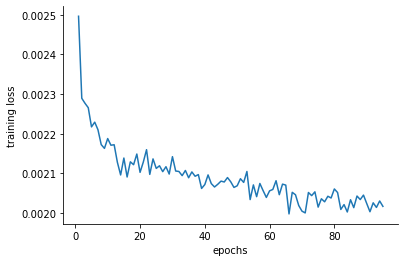

In [294]:
plt.plot(epoch, loss)
sns.despine()
plt.ylabel('training loss')
plt.xlabel('epochs')

[0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984]
[-0.975, -0.975, -0.975, -0.975, -0.975, -0.975, -0.975, -0.975, -0.975, -0.975]
[-0.975, -0.975, -0.975, -0.975, -0.975, -0.975, -0.975, -0.975, -0.975, -0.975]
[-0.9466, -0.8979, -0.802, -0.4745000000000001, -0.2627, -0.028649999999999978, 0.10410000000000001, 0.3165, 0.65835, 0.9554499999999999]


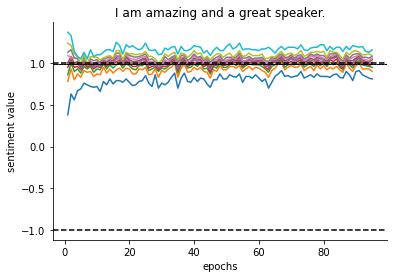

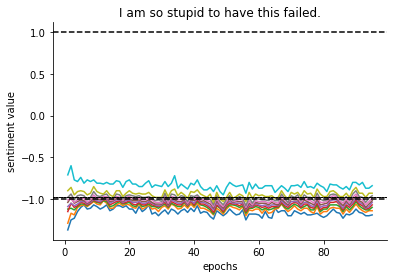

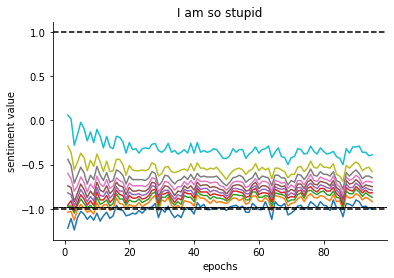

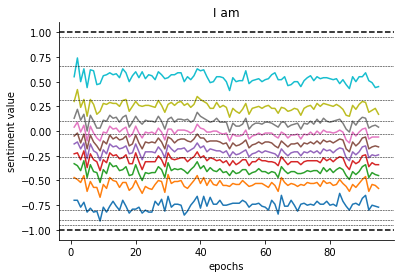

In [295]:
for example in ['I am amazing and a great speaker.',
                'I am so stupid to have this failed.', 'I am so stupid', 'I am']:

    plt.figure()
    plt.plot(epoch, np.array(log[example]))
    sns.despine()
    plt.axhline(y=-1, color='k', linestyle='--')
    plt.axhline(y=1, color='k', linestyle='--')
    plt.ylabel('sentiment value')
    plt.xlabel('epochs')
    plt.title(example)

    sel = np.array([s.startswith(example) for s in sentences]).astype('bool')
    thetas = [np.quantile(rewards[sel].squeeze(), q) for q in taus]
    print(thetas)
    for theta in thetas:
            plt.axhline(y=theta, linestyle='--', color='k', linewidth=0.5)

#### gpt model 

In [297]:
model = GPT2LMHeadModel.from_pretrained(modelname)
device='cpu'

#### examples from training set

In [27]:
example = 'I am'
inputs = tokenizer(example, return_tensors='pt').to(device)
with torch.no_grad():
    output = model(input_ids=inputs['input_ids'],
                   attention_mask=inputs['attention_mask'],
                   output_hidden_states=True)
    states = output['hidden_states'][-1]
    theta_hats = Z_network(states).detach().cpu().numpy().round(2)
    theta_hats_last = theta_hats[:,-1,:].squeeze()
print(theta_hats_last)

sel = np.array([s.startswith(example) for s in sentences]).astype('bool')
thetas = [np.quantile(rewards[sel].squeeze(), q) for q in taus]
print(np.round(thetas,2))

[-0.77 -0.58 -0.45 -0.34 -0.24 -0.16 -0.06  0.04  0.17  0.45]
[-0.95 -0.9  -0.8  -0.47 -0.26 -0.03  0.1   0.32  0.66  0.96]


In [28]:
example = 'I am not'
inputs = tokenizer(example, return_tensors='pt').to(device)
with torch.no_grad():
    output = model(input_ids=inputs['input_ids'],
                   attention_mask=inputs['attention_mask'],
                   output_hidden_states=True)
    states = output['hidden_states'][-1]
    theta_hats = Z_network(states).detach().cpu().numpy().round(2)
    theta_hats_last = theta_hats[:,-1,:].squeeze()
print(theta_hats_last)

sel = np.array([s.startswith(example) for s in sentences]).astype('bool')
thetas = [np.quantile(rewards[sel].squeeze(), q) for q in taus]
print(np.round(thetas,2))

[-0.82 -0.7  -0.62 -0.55 -0.49 -0.43 -0.37 -0.3  -0.22 -0.05]
[-0.94 -0.92 -0.9  -0.82 -0.71 -0.47 -0.37 -0.23  0.07  0.31]


In [29]:
example = 'I am very'
inputs = tokenizer(example, return_tensors='pt').to(device)
with torch.no_grad():
    output = model(input_ids=inputs['input_ids'],
                   attention_mask=inputs['attention_mask'],
                   output_hidden_states=True)
    states = output['hidden_states'][-1]
    theta_hats = Z_network(states).detach().cpu().numpy().round(2)
    theta_hats_last = theta_hats[:,-1,:].squeeze()
print(theta_hats_last)

sel = np.array([s.startswith(example) for s in sentences]).astype('bool')
thetas = [np.quantile(rewards[sel].squeeze(), q) for q in taus]
print(np.round(thetas,2))

[-1.   -0.73 -0.54 -0.39 -0.26 -0.13  0.02  0.19  0.42  0.8 ]
[-0.86 -0.86 -0.85 -0.76 -0.23  0.31  0.84  0.94  0.96  0.98]


In [65]:
taus

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

[-0.77 -0.58 -0.45 -0.34 -0.24 -0.16 -0.06  0.04  0.17  0.45]
[-0.95 -0.9  -0.8  -0.47 -0.26 -0.03  0.1   0.32  0.66  0.96]

[-0.82 -0.7  -0.62 -0.55 -0.49 -0.43 -0.37 -0.3  -0.22 -0.05]
[-0.94 -0.92 -0.9  -0.82 -0.71 -0.47 -0.37 -0.23  0.07  0.31]

[-1.   -0.73 -0.54 -0.39 -0.26 -0.13  0.02  0.19  0.42  0.8 ]
[-0.86 -0.86 -0.85 -0.76 -0.23  0.31  0.84  0.94  0.96  0.98]



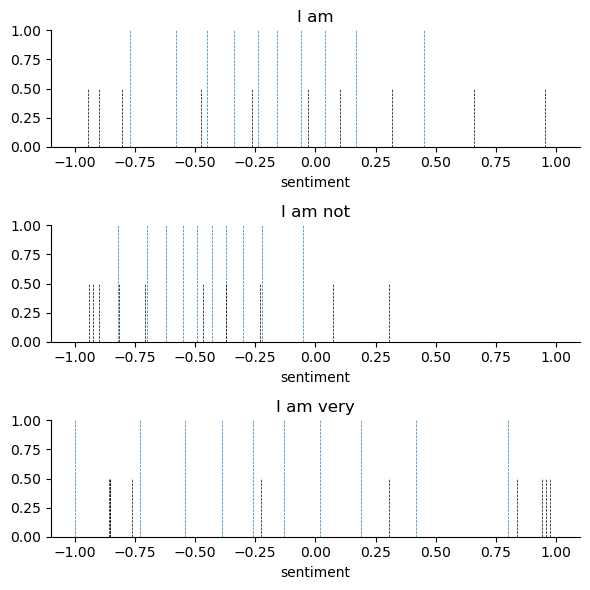

In [64]:
fig,axes = plt.subplots(3,1,figsize=(6,6), dpi=100)

for e, example in enumerate(['I am',
'I am not',
'I am very']):
    
    inputs = tokenizer(example, return_tensors='pt').to(device)
    with torch.no_grad():
        output = model(input_ids=inputs['input_ids'],
                       attention_mask=inputs['attention_mask'],
                       output_hidden_states=True)
        states = output['hidden_states'][-1]
        theta_hats = Z_network(states).detach().cpu().numpy().round(2)
        theta_hats_last = theta_hats[:,-1,:].squeeze()
    print(theta_hats_last)

    sel = np.array([s.startswith(example) for s in sentences]).astype('bool')
    sel.sum()
    thetas = [np.quantile(rewards[sel].squeeze(), q) for q in taus]
    print(np.round(thetas,2))
    print()
    
    plt.sca(axes[e])
    for theta in theta_hats_last:
        plt.axvline(x=theta, linestyle='--', linewidth=0.5)
    for theta in thetas:
        plt.axvline(x=theta, ymax=0.5, linestyle='--', linewidth=0.5, color='k')
    plt.title(example)
    plt.xlabel('sentiment')
    plt.xlim([-1.1,1.1])
    sns.despine()
plt.tight_layout()

#### examples not in training set

##### printing individually

In [313]:
example = 'I had no'
inputs = tokenizer(example, return_tensors='pt').to(device)
with torch.no_grad():
    output = model(input_ids=inputs['input_ids'],
                   attention_mask=inputs['attention_mask'],
                   output_hidden_states=True)
    states = output['hidden_states'][-1]
    theta_hats = Z_network(states).detach().cpu().numpy().round(2)
    theta_hats_last = theta_hats[:,-1,:].squeeze()
print(theta_hats_last)

sel = np.array([s.startswith(example) for s in sentences]).astype('bool')
sel.sum()
# thetas = [np.quantile(rewards[sel].squeeze(), q) for q in taus
# print(thetas)

[-0.76 -0.64 -0.56 -0.5  -0.44 -0.39 -0.34 -0.28 -0.21 -0.05]


18

In [314]:
example = 'I had no pain'
inputs = tokenizer(example, return_tensors='pt').to(device)
with torch.no_grad():
    output = model(input_ids=inputs['input_ids'],
                   attention_mask=inputs['attention_mask'],
                   output_hidden_states=True)
    states = output['hidden_states'][-1]
    theta_hats = Z_network(states).detach().cpu().numpy().round(2)
    theta_hats_last = theta_hats[:,-1,:].squeeze()
print(theta_hats_last)

sel = np.array([s.startswith(example) for s in sentences]).astype('bool')
sel.sum()
# thetas = [np.quantile(rewards[sel].squeeze(), q) for q in taus
# print(thetas)

[-0.49 -0.38 -0.3  -0.24 -0.19 -0.14 -0.09 -0.04  0.03  0.18]


0

In [30]:
example = 'I am awesome'
inputs = tokenizer(example, return_tensors='pt').to(device)
with torch.no_grad():
    output = model(input_ids=inputs['input_ids'],
                   attention_mask=inputs['attention_mask'],
                   output_hidden_states=True)
    states = output['hidden_states'][-1]
    theta_hats = Z_network(states).detach().cpu().numpy().round(2)
    theta_hats_last = theta_hats[:,-1,:].squeeze()
print(theta_hats_last)

sel = np.array([s.startswith(example) for s in sentences]).astype('bool')
sel.sum()
# thetas = [np.quantile(rewards[sel].squeeze(), q) for q in taus
# print(thetas)

[0.17 0.46 0.6  0.69 0.75 0.79 0.84 0.88 0.94 1.08]


0

In [31]:
example = 'I am not'
inputs = tokenizer(example, return_tensors='pt').to(device)
with torch.no_grad():
    output = model(input_ids=inputs['input_ids'],
                   attention_mask=inputs['attention_mask'],
                   output_hidden_states=True)
    states = output['hidden_states'][-1]
    theta_hats = Z_network(states).detach().cpu().numpy().round(2)
    theta_hats_last = theta_hats[:,-1,:].squeeze()
print(theta_hats_last)

sel = np.array([s.startswith(example) for s in sentences]).astype('bool')
sel.sum()
# thetas = [np.quantile(rewards[sel].squeeze(), q) for q in taus
# print(thetas)

[-0.82 -0.7  -0.62 -0.55 -0.49 -0.43 -0.37 -0.3  -0.22 -0.05]


52

In [32]:
example = 'This is not very'
inputs = tokenizer(example, return_tensors='pt').to(device)
with torch.no_grad():
    output = model(input_ids=inputs['input_ids'],
                   attention_mask=inputs['attention_mask'],
                   output_hidden_states=True)
    states = output['hidden_states'][-1]
    theta_hats = Z_network(states).detach().cpu().numpy().round(2)
    theta_hats_last = theta_hats[:,-1,:].squeeze()
print(theta_hats_last)

sel = np.array([s.startswith(example) for s in sentences]).astype('bool')
sel.sum()
# thetas = [np.quantile(rewards[sel].squeeze(), q) for q in taus
# print(thetas)

[-0.78 -0.68 -0.61 -0.55 -0.5  -0.45 -0.39 -0.33 -0.24 -0.07]


0

In [33]:
example = 'This is very'
inputs = tokenizer(example, return_tensors='pt').to(device)
with torch.no_grad():
    output = model(input_ids=inputs['input_ids'],
                   attention_mask=inputs['attention_mask'],
                   output_hidden_states=True)
    states = output['hidden_states'][-1]
    theta_hats = Z_network(states).detach().cpu().numpy().round(2)
    theta_hats_last = theta_hats[:,-1,:].squeeze()
print(theta_hats_last)

sel = np.array([s.startswith(example) for s in sentences]).astype('bool')
sel.sum()
# thetas = [np.quantile(rewards[sel].squeeze(), q) for q in taus
# print(thetas)

[-1.31 -1.12 -0.99 -0.88 -0.79 -0.69 -0.58 -0.45 -0.27  0.08]


3

In [34]:
example = 'I am not awesome'
inputs = tokenizer(example, return_tensors='pt').to(device)
with torch.no_grad():
    output = model(input_ids=inputs['input_ids'],
                   attention_mask=inputs['attention_mask'],
                   output_hidden_states=True)
    states = output['hidden_states'][-1]
    theta_hats = Z_network(states).detach().cpu().numpy().round(2)
    theta_hats_last = theta_hats[:,-1,:].squeeze()
print(theta_hats_last)

sel = np.array([s.startswith(example) for s in sentences]).astype('bool')
sel.sum()
# thetas = [np.quantile(rewards[sel].squeeze(), q) for q in taus
# print(thetas)

[-0.71 -0.55 -0.44 -0.34 -0.27 -0.2  -0.12 -0.04  0.06  0.27]


0

In [35]:
example = 'I am not going to fail.'
inputs = tokenizer(example, return_tensors='pt').to(device)
with torch.no_grad():
    output = model(input_ids=inputs['input_ids'],
                   attention_mask=inputs['attention_mask'],
                   output_hidden_states=True)
    states = output['hidden_states'][-1]
    theta_hats = Z_network(states).detach().cpu().numpy().round(2)
    theta_hats_last = theta_hats[:,-1,:].squeeze()
print(theta_hats_last)

sel = np.array([s.startswith(example) for s in sentences]).astype('bool')
sel.sum()
# thetas = [np.quantile(rewards[sel].squeeze(), q) for q in taus
# print(thetas)

[-0.37 -0.32 -0.27 -0.23 -0.19 -0.16 -0.12 -0.08 -0.05  0.06]


0

In [36]:
example = 'I am not going to win.'
inputs = tokenizer(example, return_tensors='pt').to(device)
with torch.no_grad():
    output = model(input_ids=inputs['input_ids'],
                   attention_mask=inputs['attention_mask'],
                   output_hidden_states=True)
    states = output['hidden_states'][-1]
    theta_hats = Z_network(states).detach().cpu().numpy().round(2)
    theta_hats_last = theta_hats[:,-1,:].squeeze()
print(theta_hats_last)

sel = np.array([s.startswith(example) for s in sentences]).astype('bool')
sel.sum()
# thetas = [np.quantile(rewards[sel].squeeze(), q) for q in taus
# print(thetas)

[-0.81 -0.78 -0.75 -0.71 -0.69 -0.66 -0.63 -0.6  -0.58 -0.5 ]


0

In [37]:
example = 'I am going to win.'
inputs = tokenizer(example, return_tensors='pt').to(device)
with torch.no_grad():
    output = model(input_ids=inputs['input_ids'],
                   attention_mask=inputs['attention_mask'],
                   output_hidden_states=True)
    states = output['hidden_states'][-1]
    theta_hats = Z_network(states).detach().cpu().numpy().round(2)
    theta_hats_last = theta_hats[:,-1,:].squeeze()
print(theta_hats_last)

sel = np.array([s.startswith(example) for s in sentences]).astype('bool')
sel.sum()
# thetas = [np.quantile(rewards[sel].squeeze(), q) for q in taus
# print(thetas)

[0.75 0.81 0.85 0.89 0.91 0.93 0.95 0.96 0.96 1.  ]


0

In [38]:
example = 'Without his help, I'
inputs = tokenizer(example, return_tensors='pt').to(device)
with torch.no_grad():
    output = model(input_ids=inputs['input_ids'],
                   attention_mask=inputs['attention_mask'],
                   output_hidden_states=True)
    states = output['hidden_states'][-1]
    theta_hats = Z_network(states).detach().cpu().numpy().round(2)
    theta_hats_last = theta_hats[:,-1,:].squeeze()
print(theta_hats_last)

sel = np.array([s.startswith(example) for s in sentences]).astype('bool')
sel.sum()
# thetas = [np.quantile(rewards[sel].squeeze(), q) for q in taus
# print(thetas)

[-0.72 -0.59 -0.49 -0.41 -0.35 -0.29 -0.22 -0.15 -0.06  0.12]


0

In [40]:
example = 'Without'
inputs = tokenizer(example, return_tensors='pt').to(device)
with torch.no_grad():
    output = model(input_ids=inputs['input_ids'],
                   attention_mask=inputs['attention_mask'],
                   output_hidden_states=True)
    states = output['hidden_states'][-1]
    theta_hats = Z_network(states).detach().cpu().numpy().round(2)
    theta_hats_last = theta_hats[:,-1,:].squeeze()
print(theta_hats_last)

sel = np.array([s.startswith(example) for s in sentences]).astype('bool')
sel.sum()
# thetas = [np.quantile(rewards[sel].squeeze(), q) for q in taus
# print(thetas)

[-0.57 -0.44 -0.35 -0.27 -0.21 -0.15 -0.08 -0.01  0.07  0.25]


7

In [41]:
example = 'With'
inputs = tokenizer(example, return_tensors='pt').to(device)
with torch.no_grad():
    output = model(input_ids=inputs['input_ids'],
                   attention_mask=inputs['attention_mask'],
                   output_hidden_states=True)
    states = output['hidden_states'][-1]
    theta_hats = Z_network(states).detach().cpu().numpy().round(2)
    theta_hats_last = theta_hats[:,-1,:].squeeze()
print(theta_hats_last)

sel = np.array([s.startswith(example) for s in sentences]).astype('bool')
sel.sum()
# thetas = [np.quantile(rewards[sel].squeeze(), q) for q in taus
# print(thetas)

[-0.46 -0.31 -0.22 -0.14 -0.08 -0.02  0.04  0.11  0.19  0.37]


41

In [39]:
example = 'With his help, I'
inputs = tokenizer(example, return_tensors='pt').to(device)
with torch.no_grad():
    output = model(input_ids=inputs['input_ids'],
                   attention_mask=inputs['attention_mask'],
                   output_hidden_states=True)
    states = output['hidden_states'][-1]
    theta_hats = Z_network(states).detach().cpu().numpy().round(2)
    theta_hats_last = theta_hats[:,-1,:].squeeze()
print(theta_hats_last)

sel = np.array([s.startswith(example) for s in sentences]).astype('bool')
sel.sum()
# thetas = [np.quantile(rewards[sel].squeeze(), q) for q in taus
# print(thetas)

[-0.15  0.04  0.15  0.24  0.31  0.38  0.45  0.52  0.62  0.81]


0

In [42]:
example = 'Despite not having his help, I'
inputs = tokenizer(example, return_tensors='pt').to(device)
with torch.no_grad():
    output = model(input_ids=inputs['input_ids'],
                   attention_mask=inputs['attention_mask'],
                   output_hidden_states=True)
    states = output['hidden_states'][-1]
    theta_hats = Z_network(states).detach().cpu().numpy().round(2)
    theta_hats_last = theta_hats[:,-1,:].squeeze()
print(theta_hats_last)

sel = np.array([s.startswith(example) for s in sentences]).astype('bool')
sel.sum()
# thetas = [np.quantile(rewards[sel].squeeze(), q) for q in taus
# print(thetas)

[-0.29 -0.11 -0.01  0.07  0.13  0.19  0.25  0.32  0.4   0.58]


0

In [43]:
example = 'Despite having his help, I'
inputs = tokenizer(example, return_tensors='pt').to(device)
with torch.no_grad():
    output = model(input_ids=inputs['input_ids'],
                   attention_mask=inputs['attention_mask'],
                   output_hidden_states=True)
    states = output['hidden_states'][-1]
    theta_hats = Z_network(states).detach().cpu().numpy().round(2)
    theta_hats_last = theta_hats[:,-1,:].squeeze()
print(theta_hats_last)

sel = np.array([s.startswith(example) for s in sentences]).astype('bool')
sel.sum()
# thetas = [np.quantile(rewards[sel].squeeze(), q) for q in taus
# print(thetas)

[-0.66 -0.51 -0.4  -0.32 -0.25 -0.18 -0.11 -0.04  0.06  0.26]


0

##### plotting examples

In [201]:
examples = ['I am awesome', 'I am not awesome', 
'I am not going to win', 'I am going to win',
'This is not very', 'This is very',
'With his help, I', 'Without his help, I',
'Without','With',
'Despite having his help, I', 'Despite not having his help, I']

In [202]:
with open('../data/results/single_sentences_IYou_2/ood_examples.txt','w') as f:
    for example in examples:
        f.write(example+'\n')

In [212]:
loaded = pickle.load(open('../data/results/single_sentences_IYou_2/odd_examples_output.pkl','rb'))
#loaded[examples[-2]]['rewards']

In [225]:
# i = -2
# print(examples[i])
# print(loaded[examples[i]]['rewards'])
# loaded[examples[i]]['ends']
example = "I am going to win"
example = 'This is not very'
np.array(loaded[example]['rewards'])
np.array(loaded[example]['ends'])
#np.array(loaded['I am awesome']['decoded'])

array(["This is not very nice and I hate this man, who thinks he's above me.",
       'This is not very healthy, and all because of a stupid big flaw of mine.',
       'This is not very fun or enjoyable.',
       'This is not very enjoyable.',
       'This is not very satisfying and therefore unworthy of lunch.',
       'This is not very entertaining.', 'This is not very fun for me.',
       'This is not very interesting to my parents.',
       'This is not very satisfying to me.',
       'This is not very satisfying.', 'This is not very satisfying.',
       'This is not very satisfying.', 'This is not very satisfying.',
       'This is not very satisfying.',
       'This is not very good as far as a game is concerned.',
       'This is not very good at all.',
       'This is not very interesting or healthy to write about.',
       'This is not very satisfying right now because the score will be low.',
       'This is not very good; go to the basketball game.',
       'This is not very

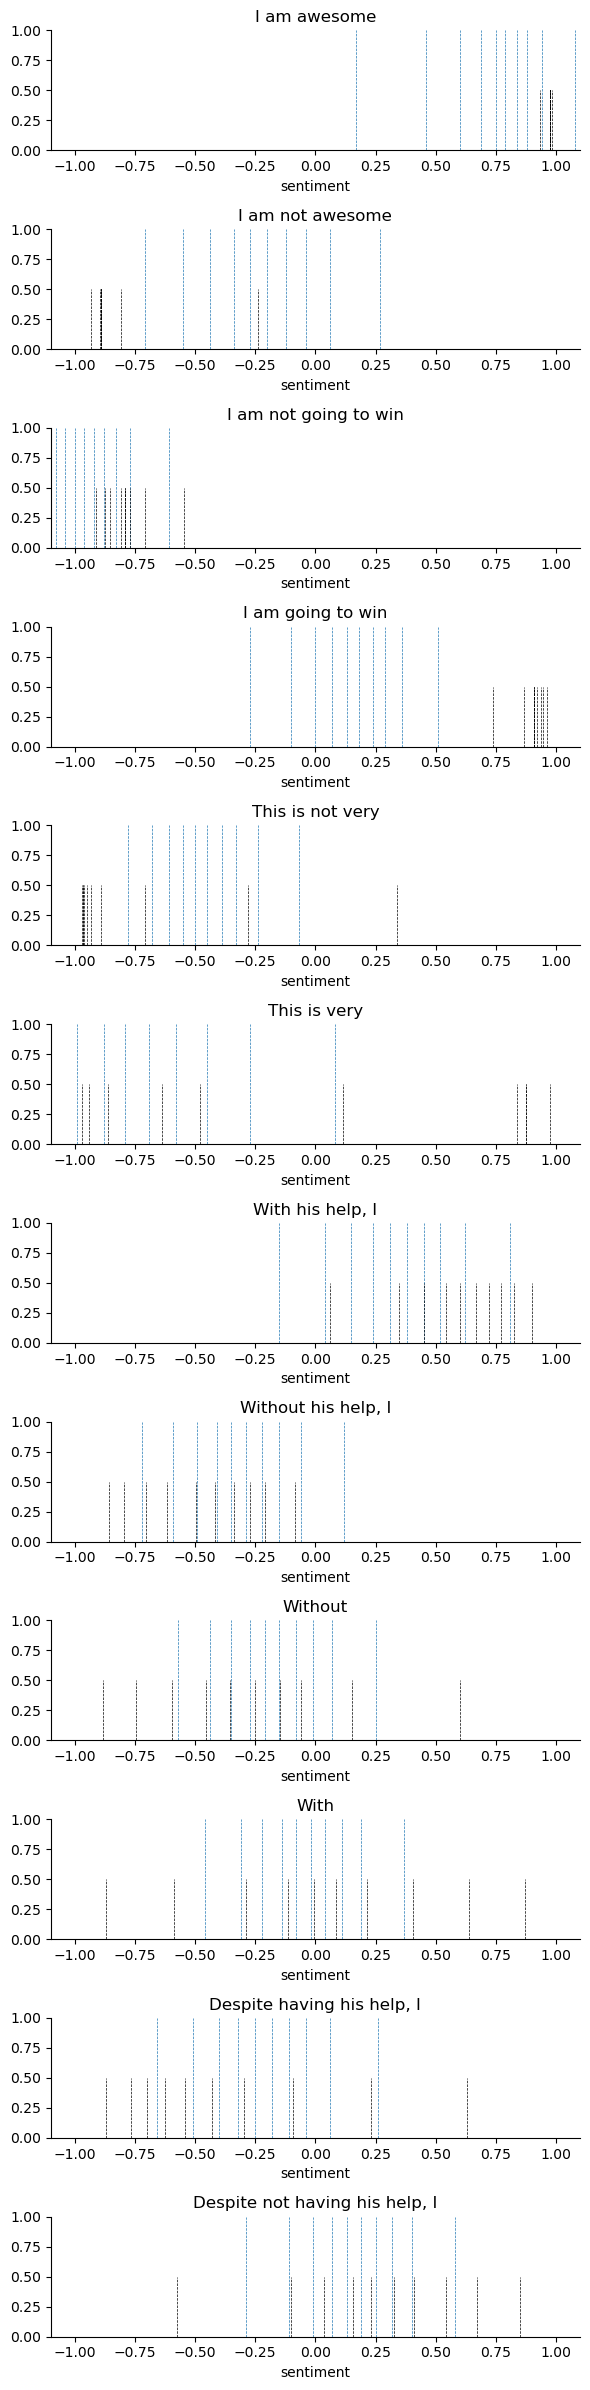

In [216]:

fig,axes = plt.subplots(int(len(examples)/1),1,figsize=(6,int(2*len(examples)/1)), dpi=100)
axes = axes.flatten()

for e, example in enumerate(examples):
    
    inputs = tokenizer(example, return_tensors='pt').to(device)
    with torch.no_grad():
        output = model(input_ids=inputs['input_ids'],
                       attention_mask=inputs['attention_mask'],
                       output_hidden_states=True)
        states = output['hidden_states'][-1]
        theta_hats = Z_network(states).detach().cpu().numpy().round(2)
        theta_hats_last = theta_hats[:,-1,:].squeeze()

    plt.sca(axes[e])
    for theta in theta_hats_last:
        plt.axvline(x=theta, linestyle='--', linewidth=0.5)

    # empirical quantiles
    thetas = [np.quantile(loaded[example]['rewards'], q) for q in taus]
    for theta in thetas:
        plt.axvline(x=theta, ymax=0.5, linestyle='--', linewidth=0.5, color='k')
        
    plt.title(example)
    plt.xlabel('sentiment')
    plt.xlim([-1.1,1.1])
    sns.despine()
plt.tight_layout()

##### plotting You enjoyed your lunch

[-0.66 -0.42 -0.29 -0.2  -0.13 -0.08 -0.03  0.03  0.09  0.24]
[0.24 0.4  0.5  0.58 0.64 0.69 0.75 0.81 0.89 1.03]
[0.21 0.41 0.52 0.62 0.69 0.76 0.83 0.9  0.99 1.16]
[0.44 0.65 0.75 0.82 0.88 0.92 0.96 0.99 1.02 1.09]


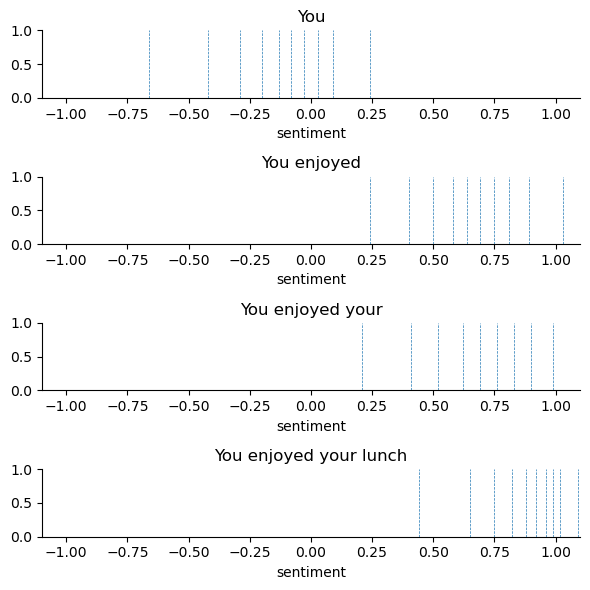

In [50]:
fig,axes = plt.subplots(4,1,figsize=(6,6), dpi=100)

for e, example in enumerate(['You',
'You enjoyed',
'You enjoyed your',
'You enjoyed your lunch']):
    
    inputs = tokenizer(example, return_tensors='pt').to(device)
    with torch.no_grad():
        output = model(input_ids=inputs['input_ids'],
                       attention_mask=inputs['attention_mask'],
                       output_hidden_states=True)
        states = output['hidden_states'][-1]
        theta_hats = Z_network(states).detach().cpu().numpy().round(2)
        theta_hats_last = theta_hats[:,-1,:].squeeze()
    print(theta_hats_last)

    sel = np.array([s.startswith(example) for s in sentences]).astype('bool')
    sel.sum()
    
    plt.sca(axes[e])
    for theta in theta_hats_last:
        plt.axvline(x=theta, linestyle='--', linewidth=0.5)
    plt.title(example)
    plt.xlabel('sentiment')
    plt.xlim([-1.1,1.1])
    sns.despine()
plt.tight_layout()

### Generating Sentences (out of distribution) using CVaR

In [65]:
import sys
sys.path.append('../')
from rl_learner import TD_Learner
import torch
import pickle
from cvar_helpers import calc_cvar_from_samples
device = 'cpu'

#### load full training data 

In [66]:
file = '../data/results/single_sentences_IYou_2/ends.txt'
f = open(file, "r")
sentences = f.readlines()
sentences = np.array([s.replace('\n','') for s in sentences])
rewards =  np.array([float(s.split('r=')[-1]) for s in sentences])

In [67]:
len(sentences)

73566

#### load cvar generated sentences

In [68]:
sentences_cvar = {}
rewards_cvar = {}
alphas = [0.05, 0.2, 0.5, 0.75]
alphas = [0.05]
top_k =10
for alpha in alphas:

    #file = f'../data/results/single_sentences_IYou_2/ends_cvar_{alpha}_unres.txt'
    file = f'../data/results/single_sentences_IYou_2/ends_cvar_{alpha}_{top_k}_unres.txt'
    f = open(file, "r")
    sentences_cvar[alpha] = np.array([s.replace('\n','') for s in f.readlines()])
    rewards_cvar[alpha] =  np.array([float(s.split('r=')[-1]) for s in sentences_cvar[alpha]])

#### Plot the distribution

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


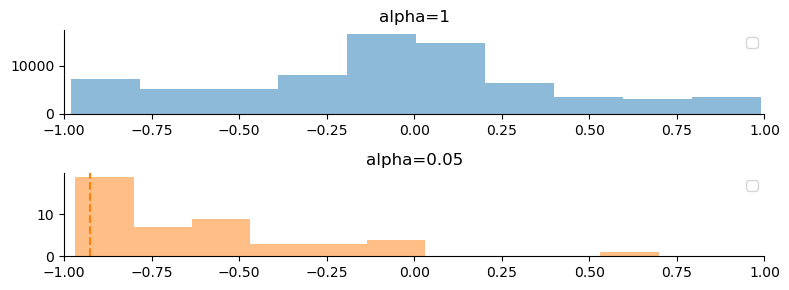

In [69]:
stem = ""
sel = np.array([s.startswith(stem) for s in sentences]).astype('bool')

fig,axes = plt.subplots(len(alphas)+1, 1, figsize=(8,3*len(alphas)), dpi=100)

plt.sca(axes[0])
plt.hist(rewards[sel], alpha=0.5, label=f'{stem}', density=False)
plt.legend()
sns.despine()
plt.xlim([-1,1])
plt.title(f'alpha=1')

for a, alpha in enumerate(alphas[::-1]):
    
    plt.sca(axes[a+1]) 
    sel_cvar = np.array([s.startswith(stem) for s in sentences_cvar[alpha]]).astype('bool')
    plt.hist(rewards_cvar[alpha][sel_cvar], alpha=0.5, color=sns.color_palette()[a+1],
             label=f'{stem}',density=False)
    
    _, cvar = calc_cvar_from_samples(rewards[sel], alpha)
    mean = np.mean(rewards_cvar[alpha][sel_cvar])
    plt.axvline(x=cvar, color=sns.color_palette()[a+1], linestyle='--')
    plt.axvline(x=mean, color=sns.color_palette()[a+1])
    plt.xlim([-1,1])
    plt.title(f'alpha={alpha}')
    
plt.legend()
plt.tight_layout()

#### Identical sentences?

In [70]:
len(sentences_cvar[0.05])

50

In [71]:
sentences
for sentence in sentences_cvar[0.05]:
    if sentence not in sentences:
        print(sentence)

I can't eat this crap. r=-0.968
I can never do this again. r=-0.959
I can't do this anymore. r=-0.953
Your body has been destroyed. r=-0.950
I might end up dead. r=-0.915
I was diagnosed with a very serious illness. r=-0.910
I can't be bothered. r=-0.909
I can't take it anymore. r=-0.908
And the test says that's not good enough. r=-0.874
I'm in pain. r=-0.862
You might fail the interview. r=-0.861
You have a headache. r=-0.847
You were late again. r=-0.761
I am late for school today, she wrote. r=-0.715
And you are not a student. r=-0.678
You're in your car driving home, and you're tired of it. r=-0.664
I'm not going to be your friend anymore, I promise. r=-0.593
You're not going to sleep in the night. r=-0.586
Or you might fail, but not for long. r=-0.515
I didn't do the test. r=-0.490
You have a lot of homework. r=-0.414
You are in a hurry. r=-0.371
I was in a hurry. r=-0.365
It's time to put your pants on. r=-0.176
You are now a student of the law. r=-0.149
You ate dinner and you dr

In [62]:
sentences
for sentence in sentences_cvar[0.2]:
    if sentence not in sentences:
        print(sentence)

KeyError: 0.2

#### Plotting p-distributions and alphas

In [72]:
alpha_storage = {}
p_storage = {}
pd_storage = {}
sentences_storage = {}
rewards_storage = {}
token_storage = {}
cvar_storage = {}
prompt_storage = {}
quantile_storage = {}
top_k=10
for alpha in [0.05]:#, 0.2, 0.5, 0.75]:

    #file = f'../data/results/single_sentences_IYou_2/cvar_output_{alpha}_unres.pkl'
    file = f'../data/results/single_sentences_IYou_2/cvar_output_{alpha}_{top_k}_unres.pkl'
    
    loaded = pickle.load(open(file,'rb'))
    alpha_storage[alpha] = loaded['alphas']
    p_storage[alpha] = loaded['p_storage']
    pd_storage[alpha] = loaded['pd_storage']
    sentences_storage[alpha] = loaded['sentences']
    rewards_storage[alpha] = loaded['rewards']
    token_storage[alpha] = loaded['token_storage']
    cvar_storage[alpha] = loaded['cvar_storage']
    quantile_storage[alpha] = loaded['quantile_storage']
    prompt_storage[alpha]= loaded['prompt_storage']

In [73]:
sentences
for sentence in sentences_storage[0.05]:
    if sentence not in sentences:
        print(sentence)

And the test says that's not good enough.
I can never do this again.
[EXCLUDED]
You're not going to sleep in the night.
And I was still awake, he says.
I was diagnosed with a very serious illness.
Your body has been destroyed.
I had no pain and no fever.
I'm so tired.
You might fail the interview.
I'm sorry.
I need to be disciplined.
I was in a hurry.
You are now a student of the law.
I need surgery.
It's just me.
Or you might fail, but not for long.
And you are not a student.
You are tired.
I can't do this anymore.
I can't sleep.
I can't be bothered.
I didn't do the test.
But you are in a class of people who, for some reason, do not fail.
I have no appetite.
You're sick.
I might fail.
It's time to put your pants on.
I might end up dead.
You ate dinner and you drank your wine and you watched your television.
You have a lot of homework.
You are in a hurry.
I need therapy.
I can't take it anymore.
[EXCLUDED]
You were late again.
I have homework.
I'm not a good student.
You have a headach

In [77]:
idx_tmp = sentences_storage[0.05].index("It's just me.")
print(idx_tmp)
idx_tmp = sentences_storage[0.05].index('But you are in a class of people who, for some reason, do not fail.')
print(idx_tmp)
i=16
np.array(p_storage[alpha][i])#.shape
#np.array(token_storage[alpha][i])

15
23


array([[0.35962993, 0.3181796 , 0.07800778, 0.06850597, 0.04091358,
        0.03475812, 0.03335879, 0.02617922, 0.02192081, 0.01854615],
       [0.66246533, 0.11353859, 0.08902004, 0.02504088, 0.0233711 ,
        0.02151264, 0.01824677, 0.01800894, 0.01485517, 0.01394046],
       [0.8541567 , 0.08128069, 0.05110508, 0.00837373, 0.0050838 ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.36446738, 0.25979906, 0.10389756, 0.08922838, 0.05760599,
        0.05512866, 0.02131725, 0.01963391, 0.01527719, 0.01364465],
       [0.45091063, 0.2060973 , 0.09891278, 0.05524275, 0.04139879,
        0.0364158 , 0.03627447, 0.03262052, 0.02713823, 0.01498869],
       [0.5926422 , 0.30059347, 0.03052621, 0.01630073, 0.01134009,
        0.01108405, 0.01068779, 0.01028414, 0.00965784, 0.00688347],
       [0.5228464 , 0.10605041, 0.09212546, 0.08800226, 0.06557997,
        0.03432341, 0.02482746, 0.02417724, 0.02152483, 0.02054261],
       [0.1994851 , 0.1741409 , 0.1095746

KeyError: 0.2

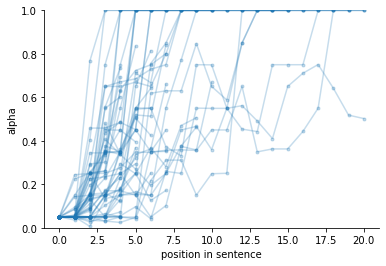

<Figure size 432x288 with 0 Axes>

In [390]:
for alpha in [0.05, 0.2, 0.5, 0.75]:
    plt.figure()
    for i in range(len(alpha_storage[alpha])):
        plt.plot(alpha_storage[alpha][i], marker='.', alpha=0.25, color=sns.color_palette()[0])
    sns.despine()
    plt.ylim([0,1])
    plt.ylabel('alpha')
    plt.xlabel('position in sentence')

KeyError: 0.2

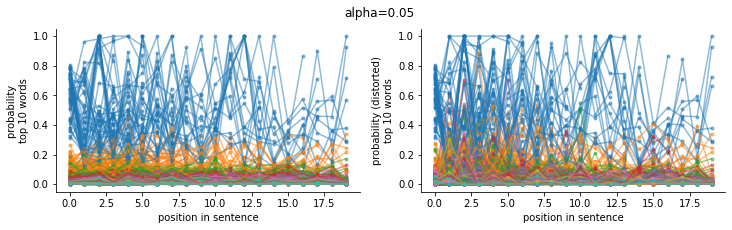

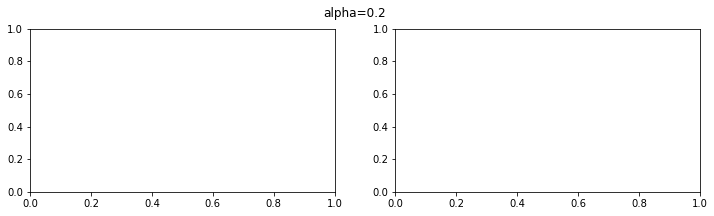

In [381]:
for alpha in [0.05, 0.2, 0.5, 0.75]:
    
    fig, axes = plt.subplots(1,2,figsize=(12,3))
    plt.suptitle(f'alpha={alpha}')

    plt.sca(axes[1])
    for i in range(len(pd_storage[alpha])):
        plt.plot(np.array(pd_storage[alpha][i]), marker='.', alpha=0.5);
        sns.despine()
    plt.ylabel('probability (distorted)\ntop 10 words')
    plt.xlabel('position in sentence')

    plt.sca(axes[0])
    for i in range(len(p_storage[alpha])):
        plt.plot(np.array(p_storage[alpha][i]), marker='.', alpha=0.5);
        sns.despine()
    plt.ylabel('probability \ntop 10 words')
    plt.xlabel('position in sentence')

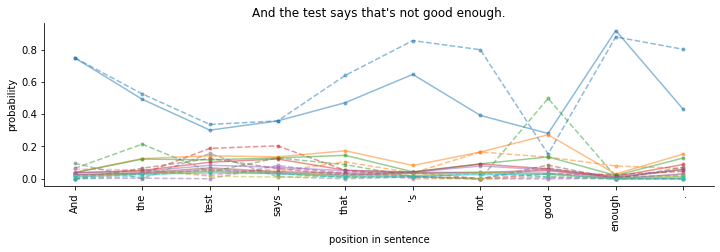

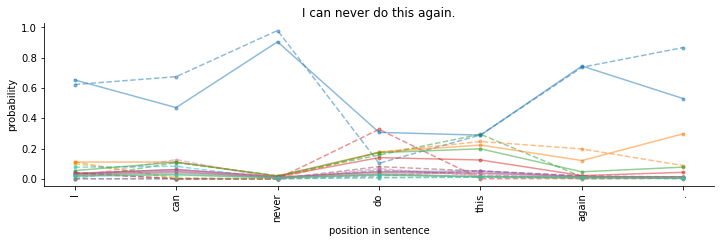

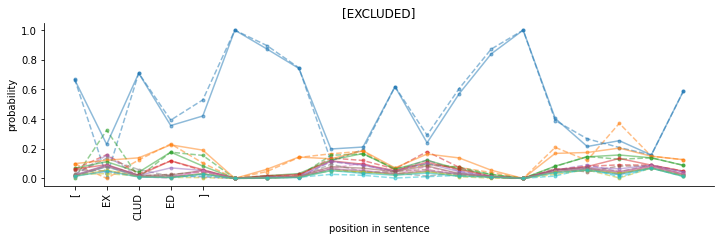

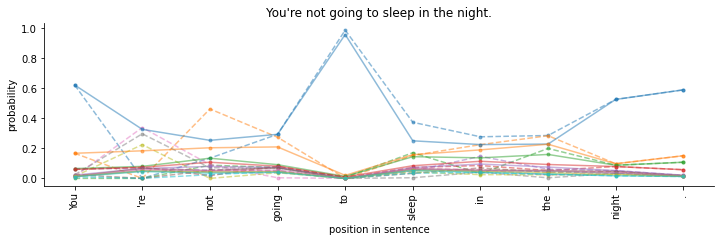

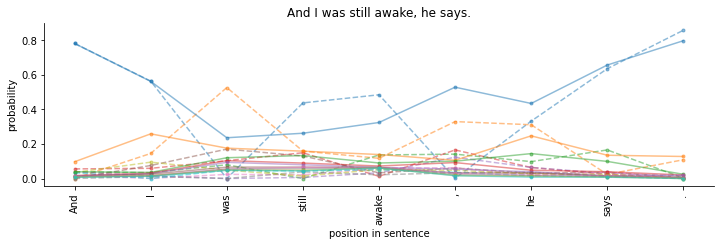

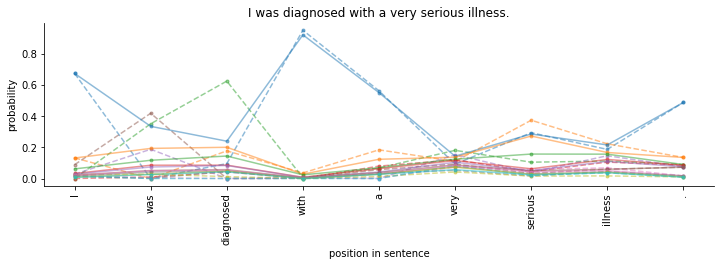

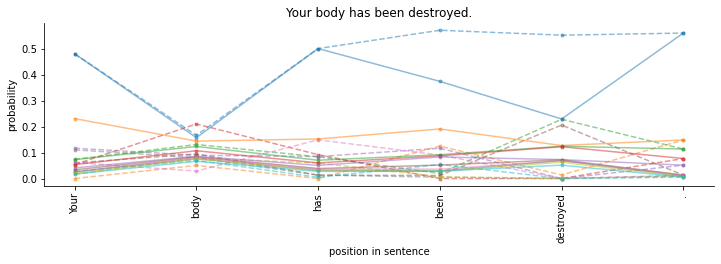

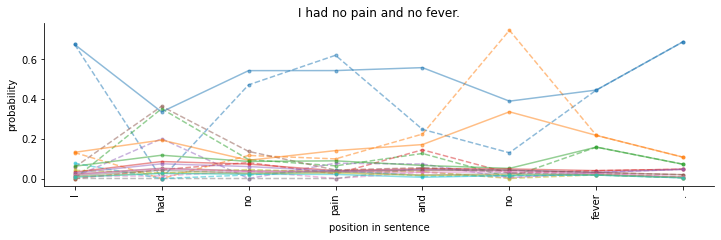

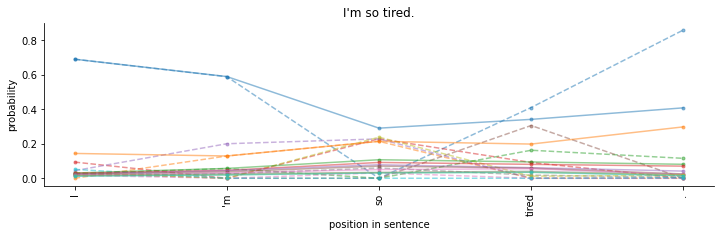

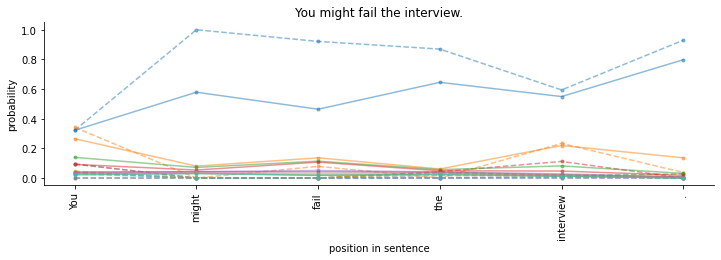

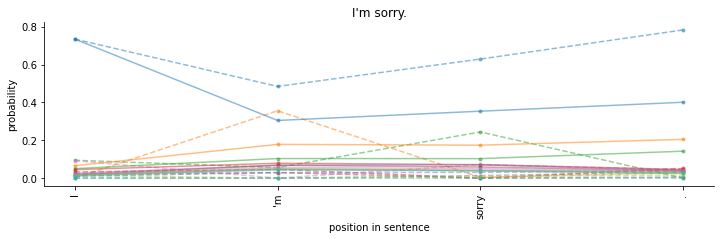

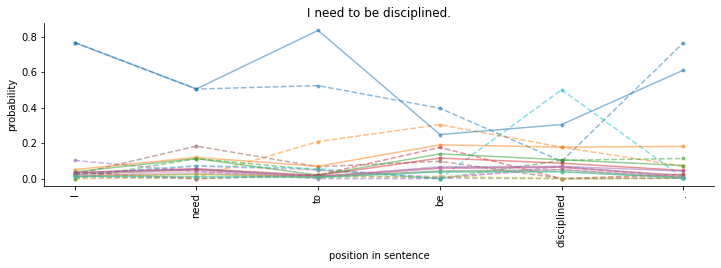

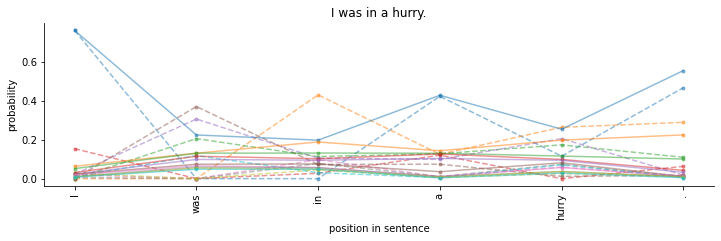

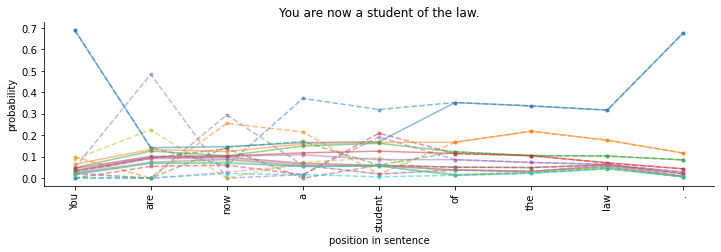

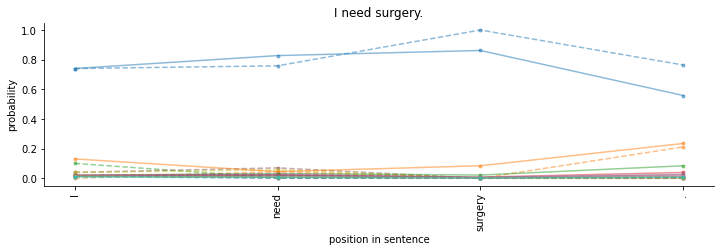

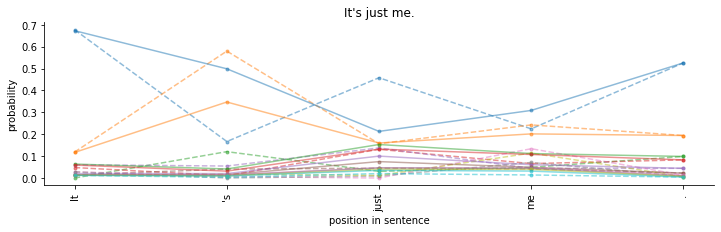

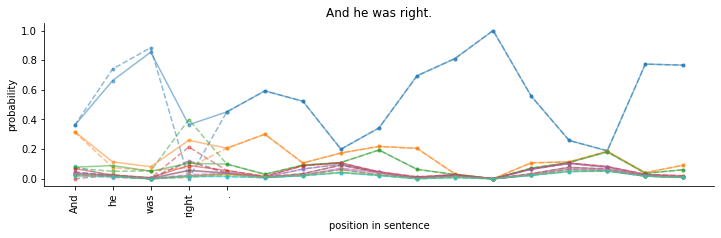

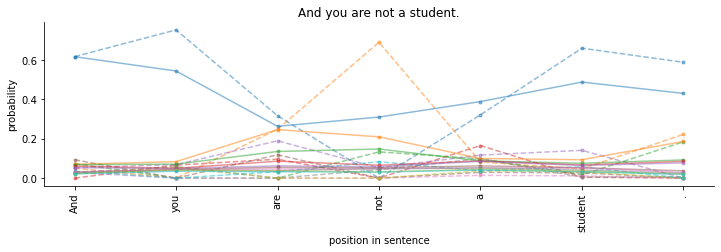

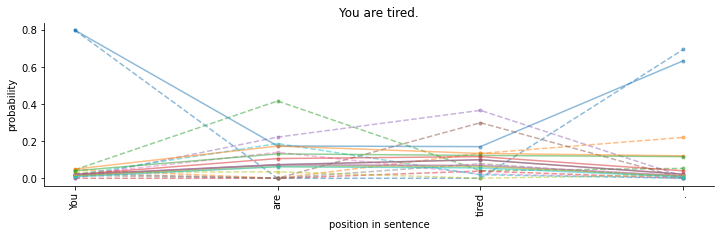

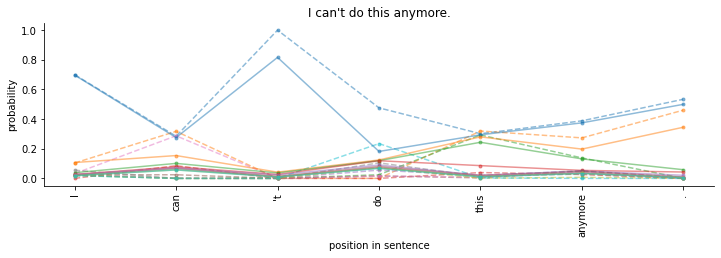

In [35]:
alpha = 0.05
for i in range(20):
    plt.figure(figsize=(12,3))
    plt.plot(np.array(pd_storage[alpha][i]), marker='.', alpha=0.5, linestyle='--', label='distorted');
    plt.plot(np.array(p_storage[alpha][i]), marker='.', alpha=0.5, label='undistorted');
    sns.despine()

    tokens = [t.replace('Ġ','') for i,t in enumerate(tokenizer.tokenize(sentences_storage[alpha][i]))]

    plt.xlabel('position in sentence')
    plt.ylabel('probability')
    plt.xticks(np.arange(len(tokens)), tokens, rotation=90)
    plt.title(sentences_storage[alpha][i])

Text(0.5, 1.0, 'And he was right.')

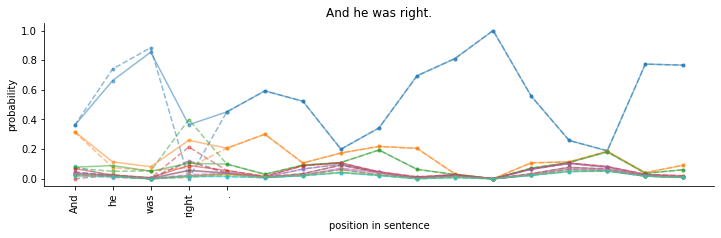

In [399]:
i = 16
plt.figure(figsize=(12,3))
plt.plot(np.array(pd_storage[alpha][i]), marker='.', alpha=0.5, linestyle='--', label='distorted');
plt.plot(np.array(p_storage[alpha][i]), marker='.', alpha=0.5, label='undistorted');
sns.despine()

tokens = [t.replace('Ġ','') for i,t in enumerate(tokenizer.tokenize(sentences_storage[alpha][i]))]

plt.xlabel('position in sentence')
plt.ylabel('probability')
plt.xticks(np.arange(len(tokens)), tokens, rotation=90)
plt.title(sentences_storage[alpha][i])

#### Printing P-distributions

In [37]:
n_quantiles = 10
taus = (2 * np.arange(n_quantiles) + 1) / (2.0 * n_quantiles)
alpha_set = list(np.append(np.insert(taus, 0, 0), 1)) # add zero, one
taus_set = list(taus)
taus_set

[0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]

In [41]:
def colored(r, g, b, text):
    return "\033[38;2;{};{};{}m{} \033[38;2;255;255;255m".format(r, g, b, text)
  
    
def create_strings(t, p, pd, diff, tokens, selected_tokens):
    probs_str = colored(0, 0, 0, 'p=\t')
    dis_probs_str = colored(0, 0, 0, 'pd=\t')
    tokens_str = 't=\t'
    
    for pi, pdi, di, tok in zip(p[t,:], pd[t,:], diff[t,:], tokens[t,:]):
        pis=str(np.round(pi,2))
        pis = colored(0, 0, 0, pis)
        probs_str+=pis
        probs_str+='\t'

        pis=str(np.round(pdi,2))
        if di<-0.05:
            pis = colored(200, 0, 0, pis)
        elif di>0.05:
            pis = colored(0, 200, 0, pis)
        else:
            pis = colored(0, 0, 0, pis)
        dis_probs_str+=pis
        dis_probs_str+='\t'
        
        tok = tok.replace('\n','NewLine')
        if tok.strip()==selected_tokens[t]:
            tok = colored(0, 0, 200, tok)
        else:
            tok = colored(0, 0, 0, tok)
        tokens_str += tok
        tokens_str += '\t'

    #if t==0:
    #    import ipdb; ipdb.set_trace()

    return(probs_str, dis_probs_str, tokens_str)

def create_cvar_strings(t, cvars, sel_alphas=[0,0.05,0.25,0.55,0.75,1.]):
    cvar_str = ''
    for alpha in sel_alphas:
        cvar_str+=str(alpha)+'\t'
        c = cvars[t,:,alpha_set.index(alpha)]
        for ci in c:
            cvar_str+=str(np.round(ci,2))
            cvar_str+='\t'
        cvar_str+='\n'
    return(cvar_str)

def create_quantile_strings(t, quantiles, sel_taus=[0.05,0.25,0.55,0.75,0.95]):
    q_str = ''
    for tau in sel_taus:
        q_str+=str(tau)+'\t'
        c = quantiles[t,:,taus_set.index(tau)]
        for ci in c:
            q_str+=str(np.round(ci,2))
            q_str+='\t'
        q_str+='\n'
    return(q_str)

In [78]:
i = 7
i = 23
i = 15
alpha=0.05
sentence = sentences_storage[alpha][i]
selected_tokens = [t.replace('Ġ','') for i,t in enumerate(tokenizer.tokenize(sentence))]
alphas_per_seq = alpha_storage[alpha][i]
prompt = prompt_storage[alpha][i]
n_tokens = len(selected_tokens)
pd = np.array(pd_storage[alpha][i])
p = np.array(p_storage[alpha][i])
tokens = np.array(token_storage[alpha][i])
diff = pd-p
cvars = np.array(cvar_storage[alpha][i])
quantiles = np.array(quantile_storage[alpha][i])

assert p.shape[0]==n_tokens

print(f'prompt: {prompt}')
print(f'{sentence}')
print()
partial_sentence = ''
for t, tok in enumerate(selected_tokens):
#for t in range(4,):
    probs_str, dis_probs_str, tokens_str = create_strings(t, p, pd, diff, tokens, selected_tokens)
    
    cvar_str = create_cvar_strings(t, cvars, sel_alphas=[0,0.05,0.25,0.55,0.75,1.])
    cvar_str = colored(0,0,0,cvar_str)
    
    q_str = create_quantile_strings(t, quantiles, sel_taus=[0.05,0.25,0.55,0.75,0.95])
    q_str = colored(0,0,0,q_str)
    
    print(colored(0, 0, 0, '--------'))
    print(colored(0, 0, 0, f'({str(np.round(alphas_per_seq[t],2))}) '+partial_sentence))
    print(colored(0, 0, 0, '--------'))
    print(tokens_str)
    print(probs_str)
    print(dis_probs_str)
    #print(cvar_str)
    print(q_str)
    print()
    
    partial_sentence+=tok+' '

    

prompt: You walked my dog to the park. You brushed my teeth. You ate breakfast.
It's just me.

-------- 
(0.05)  
-------- 
t=	 You 	 I 	NewLine 	 And 	 It 	 The 	 Your 	 But 	 Now 	 Then 	
p=	 0.67 	0.12 	0.06 	0.06 	0.02 	0.01 	0.01 	0.01 	0.01 	0.01 	
pd=	 0.68 	0.12 	0.0 	0.05 	0.06 	0.01 	0.03 	0.03 	0.01 	0.01 	
0.05	-0.63	-0.64	-0.3	-0.48	-0.64	-0.57	-0.61	-0.64	-0.49	-0.42	
0.25	-0.26	-0.25	-0.13	-0.25	-0.31	-0.32	-0.27	-0.39	-0.26	-0.22	
0.55	-0.05	-0.01	0.02	-0.07	-0.03	-0.13	-0.01	-0.18	-0.07	-0.08	
0.75	0.05	0.11	0.11	0.04	0.16	-0.0	0.16	-0.04	0.05	0.01	
0.95	0.27	0.34	0.3	0.27	0.55	0.25	0.52	0.21	0.29	0.21	
 

-------- 
(0.15) It  
-------- 
t=	 was 	's 	 wasn 	 is 	 didn 	 doesn 	 felt 	 all 	 just 	 feels 	
p=	 0.5 	0.35 	0.04 	0.03 	0.02 	0.02 	0.01 	0.01 	0.01 	0.01 	
pd=	 0.17 	0.58 	0.12 	0.01 	0.05 	0.04 	0.01 	0.0 	0.02 	0.0 	
0.05	-0.5	-0.7	-0.58	-0.51	-0.63	-0.63	-0.5	-0.35	-0.74	-0.45	
0.25	-0.15	-0.38	-0.43	-0.22	-0.48	-0.48	-0.11	-0.06	-0.41	-0.08	
0.55	0.17	-

In [43]:
n_tokens

8

In [46]:
i = 16
alpha=0.05
sentence = sentences_storage[alpha][i]
selected_tokens = [t.replace('Ġ','') for i,t in enumerate(tokenizer.tokenize(sentence))]
alphas_per_seq = alpha_storage[alpha][i]
prompt = prompt_storage[alpha][i]
n_tokens = len(selected_tokens)
pd = np.array(pd_storage[alpha][i])
p = np.array(p_storage[alpha][i])
tokens = np.array(token_storage[alpha][i])
diff = pd-p
cvars = np.array(cvar_storage[alpha][i])
quantiles = np.array(quantile_storage[alpha][i])

#assert p.shape[0]==n_tokens

print(f'prompt: {prompt}')
print(f'{sentence}')
print()
partial_sentence = ''
for t, tok in enumerate(selected_tokens):
#for t in range(4,):
    probs_str, dis_probs_str, tokens_str = create_strings(t, p, pd, diff, tokens, selected_tokens)
    
    cvar_str = create_cvar_strings(t, cvars, sel_alphas=[0,0.05,0.25,0.55,0.75,1.])
    cvar_str = colored(0,0,0,cvar_str)
    
    q_str = create_quantile_strings(t, quantiles, sel_taus=[0.05,0.25,0.55,0.75,0.95])
    q_str = colored(0,0,0,q_str)
    
    print(colored(0, 0, 0, '--------'))
    print(colored(0, 0, 0, f'({str(np.round(alphas_per_seq[t],2))}) '+partial_sentence))
    print(colored(0, 0, 0, '--------'))
    print(tokens_str)
    print(probs_str)
    print(dis_probs_str)
    #print(cvar_str)
    print(q_str)
    print()
    
    partial_sentence+=tok+' '

    

prompt: You brushed my teeth. You went to the doctors. You might fail the test.
And he was right.

-------- 
(0.05)  
-------- 
t=	 But 	 You 	 I 	NewLine 	 And 	 It 	 That 	 Maybe 	 If 	 Or 	
p=	 0.36 	0.32 	0.08 	0.07 	0.04 	0.03 	0.03 	0.03 	0.02 	0.02 	
pd=	 0.36 	0.32 	0.07 	0.0 	0.03 	0.05 	0.02 	0.05 	0.02 	0.08 	
0.05	-0.64	-0.63	-0.64	-0.3	-0.48	-0.64	-0.57	-0.7	-0.67	-0.63	
0.25	-0.39	-0.26	-0.25	-0.13	-0.25	-0.31	-0.28	-0.46	-0.45	-0.41	
0.55	-0.18	-0.05	-0.01	0.02	-0.07	-0.03	-0.03	-0.25	-0.27	-0.21	
0.75	-0.04	0.05	0.11	0.11	0.04	0.16	0.13	-0.12	-0.15	-0.08	
0.95	0.21	0.27	0.34	0.3	0.27	0.55	0.43	0.15	0.09	0.18	
 

-------- 
(0.22) And  
-------- 
t=	 you 	 maybe 	, 	 it 	 the 	 not 	 I 	 your 	 worse 	 they 	
p=	 0.66 	0.11 	0.09 	0.03 	0.02 	0.02 	0.02 	0.02 	0.01 	0.01 	
pd=	 0.74 	0.08 	0.05 	0.02 	0.02 	0.02 	0.01 	0.02 	0.03 	0.01 	
0.05	-0.74	-0.7	-0.66	-0.74	-0.68	-0.69	-0.56	-0.81	-0.88	-0.65	
0.25	-0.52	-0.46	-0.44	-0.51	-0.47	-0.5	-0.33	-0.56	-0.69	-0.45	
0.55	-

In [54]:
p_storage[0.05][i][3]

[0.36446738,
 0.25979906,
 0.103897564,
 0.08922838,
 0.05760599,
 0.055128664,
 0.021317245,
 0.01963391,
 0.01527719,
 0.013644651]

In [51]:
token_storage[0.05][i][3]

[' succeed',
 ' pass',
 ' fail',
 ' not',
 ' be',
 ' get',
 ' just',
 ' do',
 ' survive',
 ' have']

In [350]:
example = ' I had no pain and no'
inputs = tokenizer(example, return_tensors='pt').to(device)
with torch.no_grad():
    output = model(input_ids=inputs['input_ids'],
                   attention_mask=inputs['attention_mask'],
                   output_hidden_states=True)
    states = output['hidden_states'][-1]
    theta_hats = Z_network(states).detach().cpu().numpy().round(2)
    theta_hats_last = theta_hats[:,-1,:].squeeze()
print(theta_hats_last)

sel = np.array([s.startswith(example) for s in sentences]).astype('bool')
sel.sum()
# thetas = [np.quantile(rewards[sel].squeeze(), q) for q in taus
# print(thetas)

[-0.83 -0.72 -0.64 -0.58 -0.53 -0.48 -0.43 -0.36 -0.29 -0.12]


0

In [310]:
cvars.shape

(8, 10, 12)